In [633]:
import numpy as np
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import zscore
from scipy import fftpack

In [55]:
my_path = "C:/Users/ameer/Desktop/AI/ML4QS/Our data"

onlyfiles = [f for f in listdir(my_path) if isfile(join(my_path, f))]
onlyfolds = [f for f in listdir(my_path) if not isfile(join(my_path, f))]
all_files_and_folds = listdir(my_path)

In [56]:
def renaming_func(some_df):
    col_names = some_df.columns
    for nms in col_names:
        if "Time" in nms:
            some_df = some_df.rename(columns={nms:"time"})
        elif "X " in nms or " x " in nms:
            some_df = some_df.rename(columns={nms:"x"})
        elif "Y " in nms or " y " in nms:
            some_df = some_df.rename(columns={nms:"y"})
        elif "Z " in nms or " z " in nms:
            some_df = some_df.rename(columns={nms:"z"})
        elif "Pressure" in nms:
            some_df = some_df.rename(columns={nms:"pressure"})
        # else:
        #     some_df = some_df.rename(columns={nms:"source_name"})
    return some_df

In [57]:
acel = "Accelerometer.csv" 
linear_acel = "Linear Accelerometer.csv"
gyro = "Gyroscope.csv"
baro = "Barometer.csv"

file_names = [acel, linear_acel, gyro, baro]
file_names2 = ["Accelerometer.csv", "Linear Acceleration.csv", "Gyroscope.csv", "Pressure.csv"]

In [58]:
# combine data in already unzipped folders

accel_df1 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
lin_accel_df1 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
gyro_df1 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
baro_df1 = pd.DataFrame(columns=["time", "x", "source_name"],dtype=object)

df_list = [accel_df1,lin_accel_df1,gyro_df1,baro_df1]

for i in onlyfolds: #iterate through folders of social media measurements eg. "Red4 2024-06-06 20-02-55"
    for count,j in enumerate(file_names): #iterate through files in the folder
        my_df = pd.read_csv(my_path+"/"+str(i)+"/"+j) #read the tables in it
        my_df["source_name"] = str(i).split()[0] #add the name of Social Media source to a column in the dataset
        my_df = renaming_func(my_df) #simplify column names
        df_list[count] = pd.concat([df_list[count], my_df], ignore_index=True)
        
accel_df1 = df_list[0]
lin_accel_df1 = df_list[1]
gyro_df1 = df_list[2]
baro_df1 = df_list[3]

In [40]:
# #This is imputing missing gyroscope data in Reddit2

# all_gyroscope_df = pd.read_csv("C:/Users/ameer/Desktop/AI/ML4QS/all gyroscope data.csv")
# temp_df = pd.DataFrame(columns=['X (rad/s)_2', 'Y (rad/s)_2', 'Z (rad/s)_2'], dtype = object)

# X_col_ind = [i for i, cols in enumerate(all_gyroscope_df.columns) if "X (rad/s)" in cols]
# Y_col_ind = [i for i, cols in enumerate(all_gyroscope_df.columns) if "Y (rad/s)" in cols]
# Z_col_ind = [i for i, cols in enumerate(all_gyroscope_df.columns) if "Z (rad/s)" in cols]


# def process_gyro_rows(row, temp_df=temp_df):
#     sample_x = np.random.normal(loc=row[X_col_ind].mean(), scale=row[X_col_ind].std(), size=1)
#     sample_y = np.random.normal(loc=row[Y_col_ind].mean(), scale=row[Y_col_ind].std(), size=1)
#     sample_z = np.random.normal(loc=row[Z_col_ind].mean(), scale=row[Z_col_ind].std(), size=1)
#     new_row = [sample_x, sample_y, sample_z]
#     temp_df.loc[len(temp_df)] = new_row

# for index, rows in all_gyroscope_df.iterrows():
#     process_gyro_rows(row=rows)

# all_gyroscope_df = pd.concat([all_gyroscope_df, temp_df], axis=1)

# all_gyroscope_df = all_gyroscope_df.apply(pd.Series.explode)
# temp_df = temp_df.apply(pd.Series.explode)
# temp_df["Time (s)"] = all_gyroscope_df["Time (s)"]

# temp_df.to_csv('C:/Users/ameer/Desktop/AI/ML4QS/Gyroscope.csv', index=False)

In [83]:
#combine data in zipped files

accel_df2 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
lin_accel_df2 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
gyro_df2 = pd.DataFrame(columns=["time", "x", "y", "z","source_name"],dtype=object)
baro_df2 = pd.DataFrame(columns=["time", "x", "source_name"],dtype=object)

df_list2 = [accel_df2,lin_accel_df2,gyro_df2,baro_df2]
deicde_list = lambda x: file_names2 if ("FB" in x) else file_names

for i in onlyfiles: #names of zip files
        for count, j in enumerate(deicde_list(i)): #names of csv files
                with zipfile.ZipFile(my_path+"/"+str(i), 'r') as zip_ref: #unzip the zip file
                        with zip_ref.open(j) as file: #take out the csv file
                            my_df = pd.read_csv(file) #have the csv in a df
                            my_df["source_name"] = str(i).split()[0] #add the name of the source 
                            my_df = renaming_func(my_df) #change the names of the columns
                            df_list2[count] = pd.concat([df_list2[count], my_df], ignore_index=True) #take out the df and append the data to it

accel_df2 = df_list2[0]
lin_accel_df2 = df_list2[1]
gyro_df2 = df_list2[2]
baro_df2 = df_list2[3]
baro_df2['x'] = baro_df2['x'].fillna(baro_df2['pressure'])
baro_df2 = baro_df2.drop(columns=['pressure'])

In [86]:
accel_df1 = pd.concat([accel_df1,accel_df2], ignore_index=True)
lin_accel_df1 = pd.concat([lin_accel_df1,lin_accel_df2], ignore_index=True)
gyro_df1 = pd.concat([gyro_df1,gyro_df2], ignore_index=True)
baro_df1 = pd.concat([baro_df1,baro_df2], ignore_index=True)

In [100]:
my_path = 'C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets'

accel_df1.to_parquet(my_path+"/"+"all_acceleration.parquet.gzip", index = False,compression='gzip')
lin_accel_df1.to_parquet(my_path+"/"+"all_lin_acceleration.parquet.gzip", index = False,compression='gzip')
gyro_df1.to_parquet(my_path+"/"+"all_gyroscope.parquet.gzip", index = False,compression='gzip')
baro_df1.to_parquet(my_path+"/"+"all_barometer.parquet.gzip", index = False,compression='gzip')

In [495]:
my_path = 'C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets'

accel = pd.read_parquet(my_path+"/all_acceleration.parquet.gzip")
lin_accel = pd.read_parquet(my_path+"/all_lin_acceleration.parquet.gzip")
baro = pd.read_parquet(my_path+"/all_barometer.parquet.gzip")
gyro = pd.read_parquet(my_path+"/all_gyroscope.parquet.gzip")

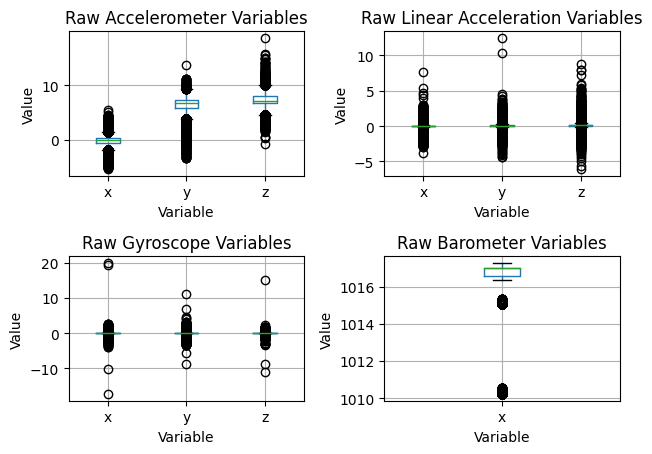

In [109]:
plt.subplot(2, 2, 1)
accel.iloc[:,1:].boxplot()
plt.title('Raw Accelerometer Variables')
plt.suptitle('')  # Suppress the automatic title to keep the plot clean
plt.xlabel('Variable')
plt.ylabel('Value')

plt.subplot(2, 2, 2)
lin_accel.iloc[:,1:].boxplot()
plt.title('Raw Linear Acceleration Variables')
plt.suptitle('')  # Suppress the automatic title to keep the plot clean
plt.xlabel('Variable')
plt.ylabel('Value')

plt.subplot(2, 2, 3)
gyro.iloc[:,1:].boxplot()
plt.title('Raw Gyroscope Variables')
plt.suptitle('')  # Suppress the automatic title to keep the plot clean
plt.xlabel('Variable')
plt.ylabel('Value')

plt.subplot(2, 2, 4)
baro.iloc[:,1:].boxplot()
plt.title('Raw Barometer Variables')
plt.suptitle('')  # Suppress the automatic title to keep the plot clean
plt.xlabel('Variable')
plt.ylabel('Value')

plt.tight_layout()

In [110]:
accel.set_index('time', inplace=True)
baro.set_index('time', inplace=True)
gyro.set_index('time', inplace=True)
lin_accel.set_index('time', inplace=True)

In [111]:
datasets = [accel, baro, gyro, lin_accel]

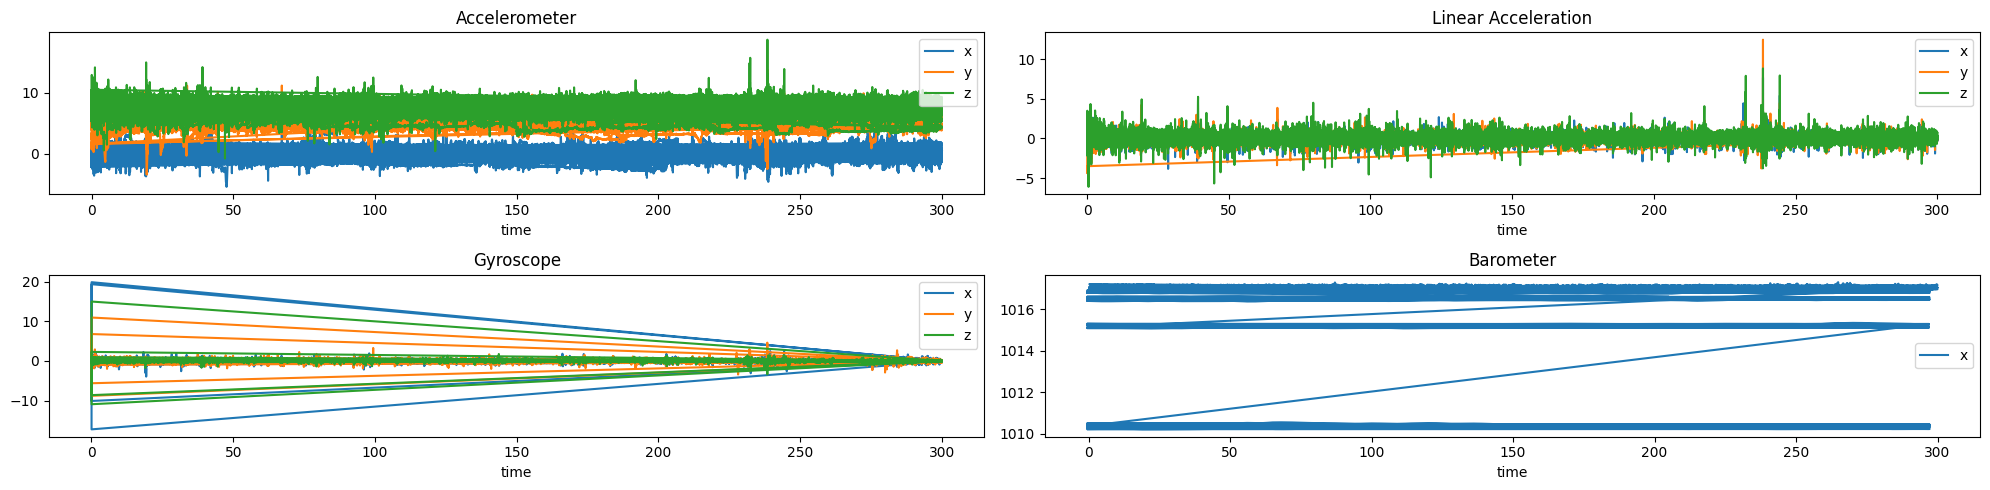

In [112]:
fig, axs = plt.subplots(2, 2, figsize=(20, 5))

accel.plot(ax=axs[0,0])
axs[0,0].set_title('Accelerometer')

lin_accel.plot(ax=axs[0,1])
axs[0,1].set_title('Linear Acceleration')

# Plot dataset3 on the third subplot
gyro.plot(ax=axs[1,0])
axs[1,0].set_title('Gyroscope')

# Plot dataset4 on the fourth subplot
baro.plot(ax=axs[1,1])
axs[1,1].set_title('Barometer')

plt.tight_layout()


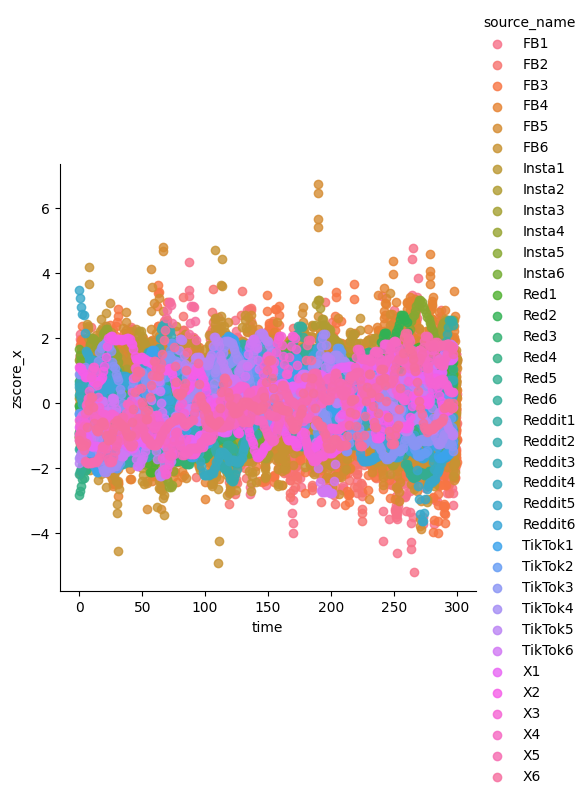

In [271]:
#sns.lmplot(x='time', y='x', data=baro, hue='source_name', fit_reg=False)
sns.lmplot(x='time', y='zscore_x', data=new_baro, hue='source_name', fit_reg=False) 

<Axes: xlabel='time', ylabel='y'>

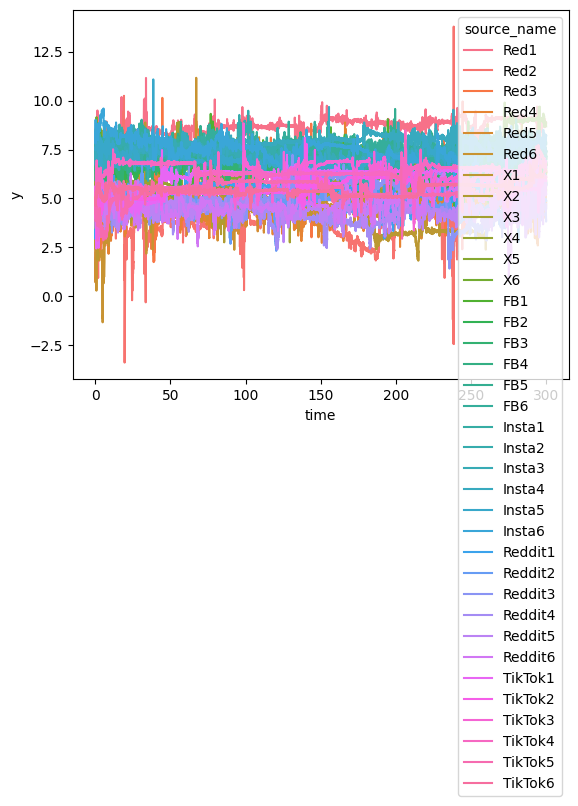

In [213]:
sns.lineplot(x='time', y='y', data=accel[["time","y", "source_name"]], hue='source_name')

In [303]:
my_path = "C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets"

accel = pd.read_parquet(my_path+"/"+"all_acceleration.parquet.gzip")
lin_accel = pd.read_parquet(my_path+"/"+"all_lin_acceleration.parquet.gzip")
gyro = pd.read_parquet(my_path+"/"+"all_gyroscope.parquet.gzip")
baro = pd.read_parquet(my_path+"/"+"all_barometer.parquet.gzip")

In [146]:
def inclination_extractor(some_df):
    return np.degrees(np.arctan2(some_df["y"],some_df["z"]))

#accel['inclination'] = inclination_extractor(accel)
# my_path = 'C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets'

# accel.to_parquet(my_path+"/"+"all_acceleration.parquet.gzip", index = False,compression='gzip')


In [234]:
def zscore_standardize_columns(some_df):

    results_df = pd.DataFrame()
    grouped = some_df.groupby('source_name')

    for name, group in grouped:
        temp_df = pd.DataFrame()
        group_df = group.copy()
        group_df = group_df.drop(columns=['time'])
        s = group_df.select_dtypes("number").columns
        temp_df[["zscore_"+x for x in group_df.loc[:,s].columns]] = group_df.loc[:,s].apply(zscore)
        temp_df[['time','source_name']] = group[['time','source_name']]
        results_df = pd.concat([results_df, temp_df])
    return results_df
        
        


In [287]:
new_baro = zscore_standardize_columns(baro)
new_accel = zscore_standardize_columns(accel)
new_lin_accel = zscore_standardize_columns(lin_accel)
new_gyro = zscore_standardize_columns(gyro)

all_baro = pd.merge(baro, new_baro, on = ['time', 'source_name'])
all_gyro = pd.merge(gyro, new_gyro, on = ['time', 'source_name'])
all_accel = pd.merge(accel, new_accel, on = ['time', 'source_name'])
all_lin_accel = pd.merge(lin_accel, new_lin_accel, on = ['time', 'source_name'])

my_path = 'C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets'
all_accel.to_parquet(my_path+"/"+"all_acceleration.parquet.gzip", index = False,compression='gzip')
all_lin_accel.to_parquet(my_path+"/"+"all_lin_acceleration.parquet.gzip", index = False,compression='gzip')
all_gyro.to_parquet(my_path+"/"+"all_gyroscope.parquet.gzip", index = False,compression='gzip')
all_baro.to_parquet(my_path+"/"+"all_barometer.parquet.gzip", index = False,compression='gzip')

In [502]:
def fourier_transformer(some_column, sampling_interval=0.05):
    fft_column = np.fft.fft(some_column)
    frequencies = np.fft.fftfreq(len(fft_column), d=sampling_interval)
    power_spectrum = np.abs(fft_column)
    weighted_sum = np.sum(frequencies * power_spectrum)
    total_magnitude = np.sum(power_spectrum)
    frequency_weighted_avg = weighted_sum / total_magnitude
    dominant_frequency = frequencies[np.argmax(power_spectrum)]
    return dominant_frequency, frequency_weighted_avg

In [626]:
def resampler(some_df, rate='50L', method="downscale", expand_features = True, acceleretor_fourier = False):
    pd.options.mode.chained_assignment = None #remove the annoying warning
    
    # Create an empty DataFrame to store resampled data
    resampled_dfs = []

    # Group the DataFrame by 'source_name'
    grouped = some_df.groupby('source_name')
    
    # Iterate over each group
    for name, group in grouped:
        # Copy the group to avoid modifying the original DataFrame
        group_df = group.copy()
        group_df['time'] = pd.to_timedelta(group_df['time'], unit='s')
        
        # Set "time" as the index
        group_df.set_index('time', inplace=True)
        resampled_group = pd.DataFrame()
        if method=="downscale" or method=="d":
            # Resample the data to the specified frequency, and choose the extreme value always
           if expand_features:
            my_col_names = group_df.drop(columns=['source_name']).columns
            resampling = group_df.drop(columns=['source_name']).resample(rate)
            resampled_group[[x+"_max" for x in my_col_names]] = resampling.max().interpolate()
            resampled_group[[x+"_min" for x in my_col_names]] = resampling.min().interpolate()
            resampled_group[[x+"_sd" for x in my_col_names]] = resampling.std().interpolate()
            resampled_group[[x+"_mean" for x in my_col_names]] = resampling.mean().interpolate()
            if acceleretor_fourier:
                tmp = resampling.apply(lambda x : fourier_transformer(x, sampling_interval=float(''.join(filter(str.isdigit, rate)))*0.001))
                resampled_group[[x+"_dominant_freq" for x in my_col_names]] = tmp.applymap(lambda x: x[0])
                resampled_group[[x+"_avg_weigh_freq" for x in my_col_names]] = tmp.applymap(lambda x: x[1])
           else:
                resampled_group = group_df.drop(columns=['source_name']).resample(rate).apply(lambda x: max(x, key=abs)).interpolate()
           
        elif method == "upscale" or method=='u':
            resampled_group = group_df.drop(columns=['source_name']).resample(rate).ffill()
        #put back the source_name to the dataframe
        resampled_group['source_name'] = name
        
        # Reset the index to have "time" as a column again, and convert it back to readable seconds
        resampled_group.reset_index(inplace=True)
        resampled_group['time'] = resampled_group['time'].dt.total_seconds()

        # Store the resampled DataFrame for this category
        resampled_dfs.append(resampled_group)

    # Concatenate all resampled DataFrames into a single DataFrame
    resampled_df = pd.concat(resampled_dfs)
    
    # Return the resampled DataFrame
    return resampled_df

In [ ]:
accel_resampled = resampler(accel, acceleretor_fourier = True)
lin_accel_resampled = resampler(lin_accel, acceleretor_fourier = True)
gyro_resampled = resampler(gyro)

#for baro, use method="d" if resampling for 1 sec
baro_resampled = resampler(baro, method="u") #since baro data are have rough granulaity in the raw data (~1 measurement/sec), we expand each measurement to duplicate values for each 0.05 sec (ie. downscaling)

In [624]:
my_path = "C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets"

accel_resampled.to_parquet(my_path+"/"+"accel_resampled.parquet.gzip", compression='gzip')
lin_accel_resampled.to_parquet(my_path+"/"+"lin_accel_resampled.parquet.gzip", compression='gzip')
gyro_resampled.to_parquet(my_path+"/"+"gyro_resampled.parquet.gzip", compression='gzip')
baro_resampled.to_parquet(my_path+"/"+"baro_resampled.parquet.gzip", compression='gzip')

In [629]:
accel_resampled_hz = resampler(accel, acceleretor_fourier = True, rate="1000L")
lin_accel_resampled_hz = resampler(lin_accel, acceleretor_fourier = True, rate="1000L")
gyro_resampled_hz = resampler(gyro, rate="1000L", acceleretor_fourier = True)

#for baro, use method="d" if resampling for 1 sec
baro_resampled_hz = resampler(baro, rate="1000L") #since baro data are have rough granulaity in the raw data (~1 measurement/sec), we expand each measurement to duplicate values for each 0.05 sec (ie. downscaling)

In [630]:
my_path = "C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets"

accel_resampled_hz.to_parquet(my_path+"/"+"accel_resampled_1hz.parquet.gzip", compression='gzip')
lin_accel_resampled_hz.to_parquet(my_path+"/"+"lin_accel_resampled_1hz.parquet.gzip", compression='gzip')
gyro_resampled_hz.to_parquet(my_path+"/"+"gyro_resampled_1hz.parquet.gzip", compression='gzip')
baro_resampled_hz.to_parquet(my_path+"/"+"baro_resampled_1hz.parquet.gzip", compression='gzip')

In [693]:
my_path = "C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets"

accel_resampled = pd.read_parquet(my_path+"/"+"accel_resampled.parquet.gzip")
lin_accel_resampled = pd.read_parquet(my_path+"/"+"lin_accel_resampled.parquet.gzip")
gyro_resampled = pd.read_parquet(my_path+"/"+"gyro_resampled.parquet.gzip")
baro_resampled = pd.read_parquet(my_path+"/"+"baro_resampled.parquet.gzip")

In [365]:
def visualizer(first_source_name, second_source_name, var = "x_mean"):
    plt.plot(accel_resampled[accel_resampled['source_name']==first_source_name]['time'],accel_resampled[accel_resampled['source_name']==first_source_name][var], color = 'green', alpha = 1)
    plt.plot(accel_resampled[accel_resampled['source_name']==second_source_name]['time'],accel_resampled[accel_resampled['source_name']==second_source_name][var], color = 'red', alpha = 0.5)

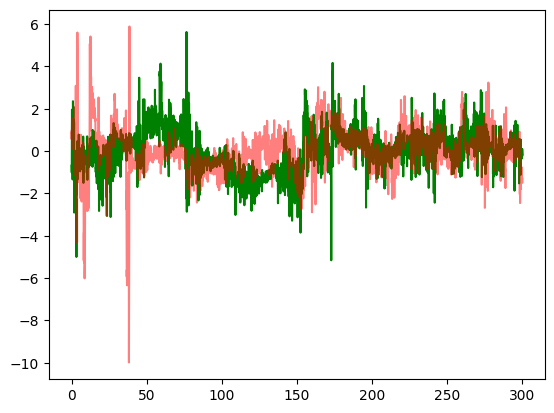

In [366]:
visualizer('FB1', 'Insta5', 'zscore_x_mean')

In [694]:
accel_resampled = accel_resampled.rename(columns=lambda x: "accel_" + x)
accel_resampled = accel_resampled.rename(columns= {"accel_time":"time", "accel_source_name":"source_name"})
lin_accel_resampled = lin_accel_resampled.rename(columns=lambda x: "linaccel_" + x)
lin_accel_resampled = lin_accel_resampled.rename(columns= {"linaccel_time":"time", "linaccel_source_name":"source_name"})
gyro_resampled = gyro_resampled.rename(columns=lambda x: "gyro_" + x)
gyro_resampled = gyro_resampled.rename(columns= {"gyro_time":"time", "gyro_source_name":"source_name"})
baro_resampled = baro_resampled.rename(columns=lambda x: "baro_" + x)
baro_resampled = baro_resampled.rename(columns= {"baro_time":"time", "baro_source_name":"source_name"})


In [795]:
def indexing_func(df):
    indecies = []
    grouped = df.groupby('source_name')
    for name, group in grouped:
        indecies.extend(np.arange(0,len(group)))
    return indecies


In [798]:
accel_resampled["index"] = indexing_func(accel_resampled)
lin_accel_resampled["index"] = indexing_func(lin_accel_resampled)
gyro_resampled["index"] = indexing_func(gyro_resampled)
baro_resampled["index"] = indexing_func(baro_resampled)

In [804]:
merged_df = pd.merge(accel_resampled, lin_accel_resampled, on=['index', 'source_name'], suffixes=('_accel', '_linaccel'))
merged_df = pd.merge(merged_df, gyro_resampled, on=['index', 'source_name'], suffixes=('_mergedpre', '_gyro'))

In [805]:
merged_df = pd.merge(merged_df, baro_resampled, on=['index', 'source_name'], suffixes=('_mergedpost', '_baro'))

In [808]:
my_path = "C:/Users/ameer/Desktop/AI/ML4QS/ml4qs_social_app/Emir_Datasets"

merged_df.to_parquet(my_path+"/full_dataset(some NAs).parquet.gzip", compression='gzip')